# Google Maps Style Route Planner With A* Search Algorithm

This project is an implementation of a route planning algorithm inspired by **_Google Maps_**. The project utilizes the **A\* search algorithm**  to find the shortest path between two points on a given map. The map is represented by a collection of intersections and roads connecting them. The algorithm calculates the optimal path by considering both the actual path cost and an estimated distance to the destination using the Euclidean distance formula. The project provides functions to create and plot maps, calculate and compute the shortest path and distance, and perform tests on maps of different complexity to verify the correctness of the algorithm. With this route planner algorithm, users can effectively plan routes on various maps, finding the most efficient path between their desired locations.

### Build Map

In [1]:
import matplotlib.pyplot as plt

In [2]:
import maps

Plot the map with 10 intersections

In [3]:
# Function for ploting the base map

def plot_map(x_lines, y_lines, x_scatters, y_scatters, markers):
    # Creating a new figure and axes with a specific size
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plotting lines on the axes
    ax.plot(x_lines, y_lines)
    # Plotting scatter points on the axes with a marker size of 500
    ax.scatter(x_scatters, y_scatters, s=400)

    # Looping through the scatter points and add a label to each scatter marker
    for x, y, label in zip(x_scatters, y_scatters, markers):
        plt.annotate(label,
                     (x, y),   # coordinates to position the label
                     textcoords="offset points",    # how to position the text
                     xytext=(0, -5),    # distance from text to points (x,y)
                     ha='center',
                     color='white',
                     size=12) 
    # Turning off the axes display
    ax.axis('off')

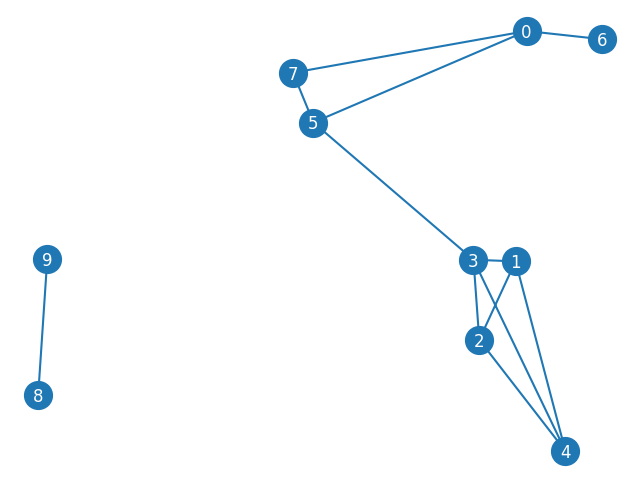

In [4]:
# Plotting the base map with 10 intersections
plot_map(maps.X_LINES_10, maps.Y_LINES_10, 
         maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
         maps.MARKERS_10)
# Displaying the plot
plt.show()

The map above shows a disconnected network of 10 intersections. The two intersections on the left are connected to each other but they are not connected to the rest of the road network. On the graph above, the edge between 2 nodes (i.e. intersections) represents a literal straight road not just an abstract connection of 2 cities.

A `Map` object, like the one above, will contain two properties that are utilized for implementing A\* search: `intersections` and `roads`

In [5]:
from math import inf, sqrt

In [6]:
# Define a class for a point or node on a map 
class Intersection:
    def __init__(self, id):
        self.id = id
        self.path_cost = None   # path cost to start point
        self.total_cost = inf    # path cost + estimated distance to goal
        self.path = [self.id]

In [7]:
# Define a Map class that contains intersections and roads properties
class Map:
    def __init__(self):
        self.intersections = None
        self.roads = None

**Intersections**

The `intersections` are represented as a dictionary. 

In this map, there are 10 intersections (or nodes), each identified by an [x,y] coordinate. The coordinates of each intersection are listed below

In [8]:
# Create a Map object for the 10-intersection map
map_10 = Map()

In [9]:
# Populate the intersections property of the map 
# with markers and corresponding x, y coordinates
map_10.intersections = {
    marker: [x, y] for marker, x, y in zip(
        maps.MARKERS_10, maps.X_SCATTERS_10, maps.Y_SCATTERS_10
    )
}
map_10.intersections

{0: [0.7798606835438107, 0.6922727646627362],
 1: [0.7647837074641568, 0.3252670836724646],
 2: [0.7155217893995438, 0.20026498027300055],
 3: [0.7076566826610747, 0.3278339270610988],
 4: [0.8325506249953353, 0.02310946309985762],
 5: [0.49016747075266875, 0.5464878695400415],
 6: [0.8820353070895344, 0.6791919587749445],
 7: [0.46247219371675075, 0.6258061621642713],
 8: [0.11622158839385677, 0.11236327488812581],
 9: [0.1285377678230034, 0.3285840695698353]}

**Roads**

The `roads` property is a dictionary where, if `i` is an intersection, `roads[i]` contains a list of the intersections that intersection `i` connects to.

In [10]:
# Create lists of (x, y) coordinates for 'from' and 'to' 
# points based on provided x_lines and y_lines
from_xy_10 = [
    [maps.X_LINES_10[i], maps.Y_LINES_10[i]] 
    for i in range(len(maps.X_LINES_10)) 
    if i % 3 == 0
]

to_xy_10 = [
    [maps.X_LINES_10[i], maps.Y_LINES_10[i]] 
    for i in range(len(maps.X_LINES_10)) 
    if i % 3 == 1
]

In [11]:
from_xy_10

[[0.7798606835438107, 0.6922727646627362],
 [0.7798606835438107, 0.6922727646627362],
 [0.7798606835438107, 0.6922727646627362],
 [0.7647837074641568, 0.3252670836724646],
 [0.7647837074641568, 0.3252670836724646],
 [0.7647837074641568, 0.3252670836724646],
 [0.7155217893995438, 0.20026498027300055],
 [0.7155217893995438, 0.20026498027300055],
 [0.7076566826610747, 0.3278339270610988],
 [0.7076566826610747, 0.3278339270610988],
 [0.49016747075266875, 0.5464878695400415],
 [0.11622158839385677, 0.11236327488812581]]

In [12]:
to_xy_10

[[0.46247219371675075, 0.6258061621642713],
 [0.8820353070895344, 0.6791919587749445],
 [0.49016747075266875, 0.5464878695400415],
 [0.8325506249953353, 0.02310946309985762],
 [0.7076566826610747, 0.3278339270610988],
 [0.7155217893995438, 0.20026498027300055],
 [0.8325506249953353, 0.02310946309985762],
 [0.7076566826610747, 0.3278339270610988],
 [0.49016747075266875, 0.5464878695400415],
 [0.8325506249953353, 0.02310946309985762],
 [0.46247219371675075, 0.6258061621642713],
 [0.1285377678230034, 0.3285840695698353]]

In [13]:
# Find the intersection ID corresponding to the 'from' points
from_intersections_10 = []
for xy in from_xy_10:
    for key, value in map_10.intersections.items():
        if value == xy:
            from_intersections_10.append(key)

# Find the intersection ID corresponding to the 'to' points
to_intersections_10 = []
for xy in to_xy_10:
    for key, value in map_10.intersections.items():
        if value == xy:
            to_intersections_10.append(key)

In [14]:
print(from_intersections_10)
print(to_intersections_10)

[0, 0, 0, 1, 1, 1, 2, 2, 3, 3, 5, 8]
[7, 6, 5, 4, 3, 2, 4, 3, 5, 4, 7, 9]


In [15]:
# Create pairs of 'from' and 'to' intersections, ensuring 
# bidirectional connections
from_to_10 = [
    (from_, to_) 
    for from_, to_ in zip(from_intersections_10, to_intersections_10)
]

from_to_10.extend(
    [
        (to_, from_) 
        for from_, to_ in zip(from_intersections_10, to_intersections_10)
    ]
)

from_to_10 = sorted(from_to_10)
from_to_10

[(0, 5),
 (0, 6),
 (0, 7),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 1),
 (2, 3),
 (2, 4),
 (3, 1),
 (3, 2),
 (3, 4),
 (3, 5),
 (4, 1),
 (4, 2),
 (4, 3),
 (5, 0),
 (5, 3),
 (5, 7),
 (6, 0),
 (7, 0),
 (7, 5),
 (8, 9),
 (9, 8)]

In [16]:
# Initialize the roads property of the map with empty lists for 
# each intersection
map_10.roads = {
    intersection: [] for intersection in map_10.intersections.keys()
}

# Add connections between intersections to the map's roads property
for from_, to_ in from_to_10:
    map_10.roads[from_].append(to_)

In [17]:
# This shows the full connectivity of the map
map_10.roads

{0: [5, 6, 7],
 1: [2, 3, 4],
 2: [1, 3, 4],
 3: [1, 2, 4, 5],
 4: [1, 2, 3],
 5: [0, 3, 7],
 6: [0],
 7: [0, 5],
 8: [9],
 9: [8]}

Pack all the steps above into a function that returns Map object.

In [18]:
def create_map(x_lines, y_lines, x_scatters, y_scatters, markers):
    # Create a new Map object
    map = Map()

    # Populate the intersections property of the map with markers and 
    # corresponding x, y coordinates
    map.intersections = {
        marker: [x, y] for marker, x, y in zip(markers, x_scatters, y_scatters)
    }

    # Create lists of (x, y) coordinates for 'from' and 'to' points based 
    # on provided x_lines and y_lines
    from_xy = [
        [x_lines[i], y_lines[i]] for i in range(len(x_lines)) if i % 3 == 0
    ]
    to_xy = [
        [x_lines[i], y_lines[i]] for i in range(len(x_lines)) if i % 3 == 1
    ]

    # Find the intersection ID corresponding to the 'from' points
    from_intersections = []
    for xy in from_xy:
        for key, value in map.intersections.items():
            if value == xy:
                from_intersections.append(key)

    # Find the intersection ID corresponding to the 'to' points
    to_intersections = []
    for xy in to_xy:
        for key, value in map.intersections.items():
            if value == xy:
                to_intersections.append(key)

    # Create pairs of 'from' and 'to' intersections, ensuring bidirectional 
    # connections
    from_to = [
        (from_, to_) for from_, to_ in zip(from_intersections, to_intersections)
    ]
    from_to.extend([
        (to_, from_) for from_, to_ in zip(from_intersections, to_intersections)
    ])
    from_to = sorted(from_to)

    # Initialize the roads property of the map with empty lists for 
    # each intersection
    map.roads = {intersection: [] for intersection in map.intersections.keys()}

    # Add connections between intersections to the map's roads property
    for from_, to_ in from_to:
        map.roads[from_].append(to_)
        
    # Return the created map
    return map

### Implement A* Search Algorithm
The algorithm is responsible for generating the shortest `path` from start to goal. 
```bash
> shortest_path(map_10, start=4, goal=6)
[4, 3, 5, 0, 6]
```

In [19]:
# Return the straight-line distance between two points

def euclidean_distance(map: Map, origin_point: int, destination_point: int) -> float:
    # Get the (x, y) coordinates of the origin and destination points
    origin_x, origin_y = map.intersections[origin_point]
    destination_x, destination_y = map.intersections[destination_point]
    
    # Calculate and return the Euclidean distance between the origin 
    # and destination points using the coordinates
    return sqrt((origin_x - destination_x)**2 + (origin_y - destination_y)**2)

In [20]:
# My Route Planning Algorithm that returns the list of intersections 
# along the shortest path, and the corresponding shortest distance 
# from the origin to the goal.

def compute_shortest_path(map: Map, start: int, goal: int):
    # Check if the start or goal point does not exist on the map
    if start not in map.intersections or goal not in map.intersections:
        print("We couldn't locate your current location or destination "
              "on the map. Please try again.")
        return None, None
    
    # Create a dictionary for intersections that are not visited, initializing 
    # each Intersection object with its ID
    unexplored = {
        intersect_id: Intersection(intersect_id) 
        for intersect_id in map.intersections.keys()
    }
    # Create an empty dictionary for frontiers, which will contain the candidate 
    # intersections to explore that are connected to the current intersection
    frontiers = {}
    
    # Set up the start intersection as the initial frontier
    start_intersection = unexplored[start]
    start_intersection.path_cost = 0
    start_intersection.total_cost = euclidean_distance(map, start, goal)
    frontiers[start] = start_intersection
    
    # Start the exploration process
    while frontiers:
        # Move on to the frontier node with the lowest total cost
        current_id, current_intersection = sorted(
            frontiers.items(), key=lambda x: x[1].total_cost
        )[0]
        
        # Check if the current intersection matches the goal
        if current_id == goal:
            break
            
        # Remove the current intersection from the unexplored and frontiers
        del unexplored[current_id]
        del frontiers[current_id]
        
        # Update the properties of connected intersections
        for connected_id in map.roads[current_id]:
            # Check if the connected intersection is unexplored
            if connected_id in unexplored:
                connected_intersection = unexplored[connected_id]
                # Calculate the new path cost and total cost for the connected intersection
                path_cost = (
                    current_intersection.path_cost 
                    + euclidean_distance(map, current_id, connected_id)
                )                
                total_cost = (
                    path_cost + euclidean_distance(map, connected_id, goal)
                )
                
                # Update the connected intersection's path and costs if the current path 
                # leads to a lower total cost
                if total_cost < connected_intersection.total_cost:
                    connected_intersection.total_cost = total_cost
                    connected_intersection.path_cost = path_cost
                    connected_intersection.path = (
                        current_intersection.path + [connected_id]
                    )
                # Add or update the connected intersection in frontiers dictionary
                frontiers[connected_id] = connected_intersection

    # Check if the goal is disconnected to the start
    if not frontiers:
        print("It is not possible to reach your destination from your "
              "current location.")
        return None, None
    
    # Return the path and total cost of the current intersection as the result if the 
    # current intersection matches the goal
    return current_intersection.path, current_intersection.total_cost

### Test Algorithm
If the code below produces no errors, the algorithm is behaving correctly.

In [21]:
def test(map, start, goal, actual_shortest_path, x_lines, y_lines, x_scatters, 
         y_scatters, markers, show_plot=True):
    print("-" * 80)
    
    # Call the compute_shortest_path() function to calculate the shortest path and distance 
    # for given start and goal points on the map
    algo_shortest_path, algo_shortest_distance = compute_shortest_path(
        map, start, goal
    )
    
    # Print the test information including start, goal, shortest path computed, correct answer, 
    # and shortest distance calculated
    print("Start:", start, 
          "\tGoal:", goal,
          "\tShortest Path By My Algorithm:", algo_shortest_path,
          "\t\tActual Shortest Path:", actual_shortest_path,
          "\nShortest Distance By My Algorithm:", algo_shortest_distance)
    
    if show_plot:
        # Check if the computed shortest path exists
        if algo_shortest_path:
            # Extract the X and Y coordinates of the intersections in the computed shortest path
            X_highlighted = [
                map.intersections[intersection][0] 
                for intersection in algo_shortest_path
            ]
            Y_highlighted = [
                map.intersections[intersection][1] 
                for intersection in algo_shortest_path
            ]

            # Plot the basic map
            plot_map(x_lines, y_lines, x_scatters, y_scatters, markers)
            # Highlight the computed shortest path in red
            plt.plot(X_highlighted, Y_highlighted, color='red')
            plt.scatter(X_highlighted, Y_highlighted, color='red', s=400)
            # Displaying the plot
            plt.show()
    
    # Check if the shortest path computed matches the actual shortest path
    result = 'Test Result: Pass' if algo_shortest_path == actual_shortest_path \
        else 'Test Result: Fail'
    return result

--------------------------------------------------------------------------------
Start: 4 	Goal: 6 	Shortest Path By My Algorithm: [4, 3, 5, 0, 6] 		Actual Shortest Path: [4, 3, 5, 0, 6] 
Shortest Distance By My Algorithm: 1.0650428104281189


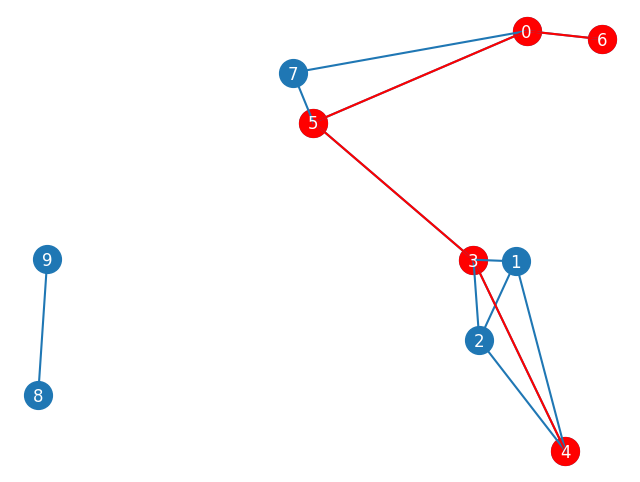

Test Result: Pass
--------------------------------------------------------------------------------
Start: 7 	Goal: 6 	Shortest Path By My Algorithm: [7, 0, 6] 		Actual Shortest Path: [7, 0, 6] 
Shortest Distance By My Algorithm: 0.4272819872602256


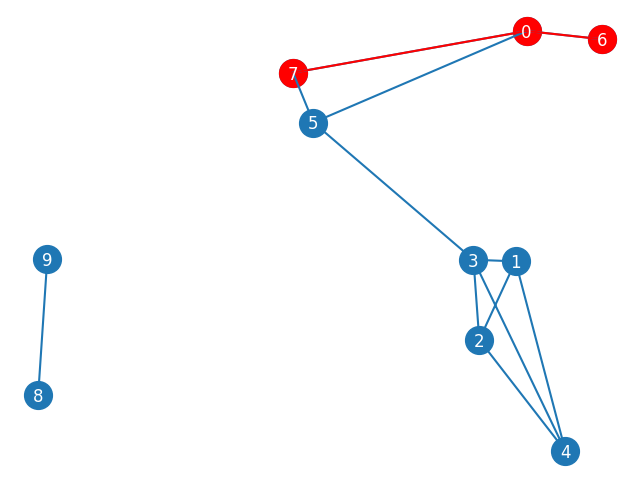

Test Result: Pass
--------------------------------------------------------------------------------
Start: 3 	Goal: 3 	Shortest Path By My Algorithm: [3] 		Actual Shortest Path: [3] 
Shortest Distance By My Algorithm: 0.0


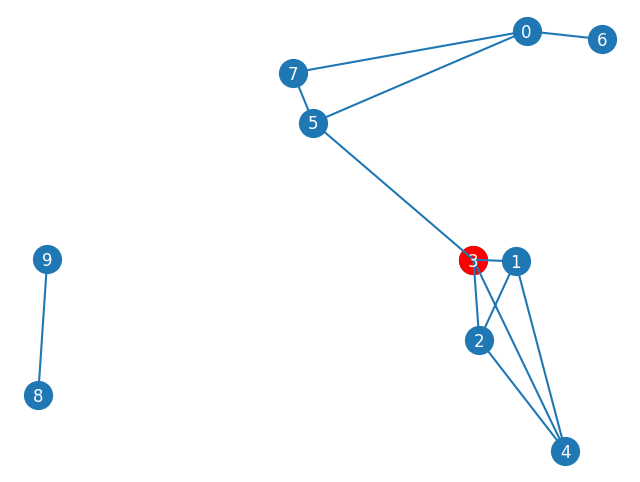

Test Result: Pass
--------------------------------------------------------------------------------
We couldn't locate your current location or destination on the map. Please try again.
Start: 12 	Goal: 3 	Shortest Path By My Algorithm: None 		Actual Shortest Path: None 
Shortest Distance By My Algorithm: None
Test Result: Pass
--------------------------------------------------------------------------------
We couldn't locate your current location or destination on the map. Please try again.
Start: 3 	Goal: 12 	Shortest Path By My Algorithm: None 		Actual Shortest Path: None 
Shortest Distance By My Algorithm: None
Test Result: Pass
--------------------------------------------------------------------------------
Start: 8 	Goal: 9 	Shortest Path By My Algorithm: [8, 9] 		Actual Shortest Path: [8, 9] 
Shortest Distance By My Algorithm: 0.2165712823264454


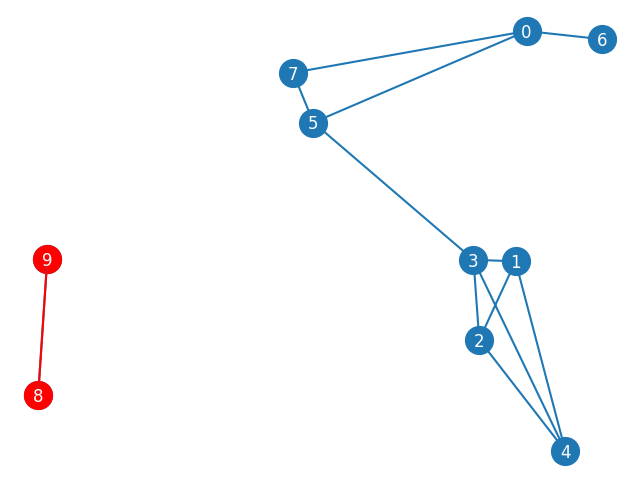

Test Result: Pass
--------------------------------------------------------------------------------
It is not possible to reach your destination from your current location.
Start: 6 	Goal: 8 	Shortest Path By My Algorithm: None 		Actual Shortest Path: None 
Shortest Distance By My Algorithm: None
Test Result: Pass


In [22]:
print(test(map_10, 4, 6, [4, 3, 5, 0, 6], 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))
print(test(map_10, 7, 6, [7, 0, 6], 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))
print(test(map_10, 3, 3, [3], 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))
print(test(map_10, 12, 3, None, 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))
print(test(map_10, 3, 12, None, 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))
print(test(map_10, 8, 9, [8, 9], 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))
print(test(map_10, 6, 8, None, 
           maps.X_LINES_10, maps.Y_LINES_10, 
           maps.X_SCATTERS_10, maps.Y_SCATTERS_10, 
           maps.MARKERS_10, True))

### Apply Route Planner Algorithm to Bigger Map

Apply the route planner algorithm to a bigger map with 40 intersections and more complex connections.

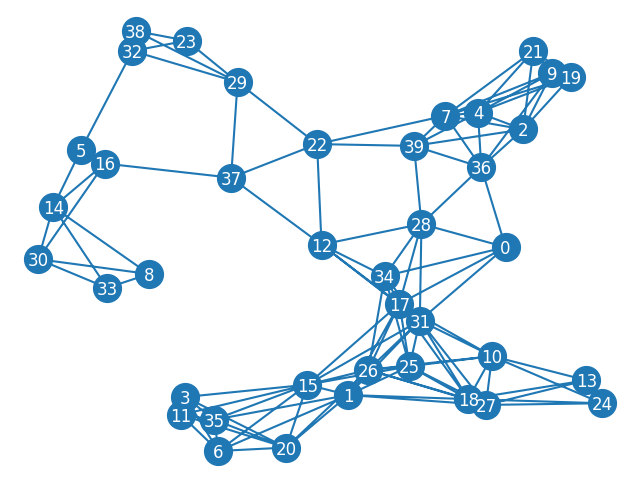

In [23]:
# Plotting the base map with 40 intersections
plot_map(maps.X_LINES_40, maps.Y_LINES_40, 
         maps.X_SCATTERS_40, maps.Y_SCATTERS_40, 
         maps.MARKERS_40)
# Displaying the plot
plt.show()

In [24]:
# create a Map object for the 40-intersection map
map_40 = create_map(maps.X_LINES_40, maps.Y_LINES_40, 
                    maps.X_SCATTERS_40, maps.Y_SCATTERS_40, 
                    maps.MARKERS_40)

In [25]:
map_40.intersections

{0: [0.7801603911549438, 0.49474860768712914],
 1: [0.5249831588690298, 0.14953665513987202],
 2: [0.8085335344099086, 0.7696330846542071],
 3: [0.2599134798656856, 0.14485659826020547],
 4: [0.7353838928272886, 0.8089961609345658],
 5: [0.09088671576431506, 0.7222846879290787],
 6: [0.313999018186756, 0.01876171413125327],
 7: [0.6824813442515916, 0.8016111783687677],
 8: [0.20128789391122526, 0.43196344222361227],
 9: [0.8551947714242674, 0.9011339078096633],
 10: [0.7581736589784409, 0.24026772497187532],
 11: [0.25311953895059136, 0.10321622277398101],
 12: [0.4813859169876731, 0.5006237737207431],
 13: [0.9112422509614865, 0.1839028760606296],
 14: [0.04580558670435442, 0.5886703168399895],
 15: [0.4582523173083307, 0.1735506267461867],
 16: [0.12939557977525573, 0.690016328140396],
 17: [0.607698913404794, 0.362322730884702],
 18: [0.719569201584275, 0.13985272363426526],
 19: [0.8860336256842246, 0.891868301175821],
 20: [0.4238357358399233, 0.026771817842421997],
 21: [0.825249

In [26]:
map_40.roads

{0: [17, 28, 31, 34, 36],
 1: [6, 15, 17, 18, 20, 25, 26, 27, 31, 35],
 2: [4, 7, 9, 19, 21, 36, 39],
 3: [6, 11, 15, 20, 35],
 4: [2, 7, 9, 19, 21, 36, 39],
 5: [14, 16, 32],
 6: [1, 3, 11, 15, 20, 35],
 7: [2, 4, 9, 19, 21, 22, 36, 39],
 8: [14, 30, 33],
 9: [2, 4, 7, 19, 21, 36],
 10: [13, 17, 18, 24, 25, 26, 27, 31],
 11: [3, 6, 15, 20, 35],
 12: [17, 22, 28, 31, 34, 37],
 13: [10, 18, 24, 27],
 14: [5, 8, 16, 30, 33],
 15: [1, 3, 6, 11, 17, 20, 25, 26, 31, 35],
 16: [5, 14, 30, 37],
 17: [0, 1, 10, 12, 15, 18, 25, 26, 28, 31, 34],
 18: [1, 10, 13, 17, 24, 25, 26, 27, 31],
 19: [2, 4, 7, 9, 21],
 20: [1, 3, 6, 11, 15, 26, 35],
 21: [2, 4, 7, 9, 19],
 22: [7, 12, 29, 37, 39],
 23: [29, 32, 38],
 24: [10, 13, 18, 27],
 25: [1, 10, 15, 17, 18, 26, 27, 31, 34],
 26: [1, 10, 15, 17, 18, 20, 25, 27, 31, 34],
 27: [1, 10, 13, 18, 24, 25, 26, 31],
 28: [0, 12, 17, 31, 34, 36, 39],
 29: [22, 23, 32, 37, 38],
 30: [8, 14, 16, 33],
 31: [0, 1, 10, 12, 15, 17, 18, 25, 26, 27, 28, 34],
 32: [5,

--------------------------------------------------------------------------------
Start: 5 	Goal: 34 	Shortest Path By My Algorithm: [5, 16, 37, 12, 34] 		Actual Shortest Path: [5, 16, 37, 12, 34] 
Shortest Distance By My Algorithm: 0.5987679064881427


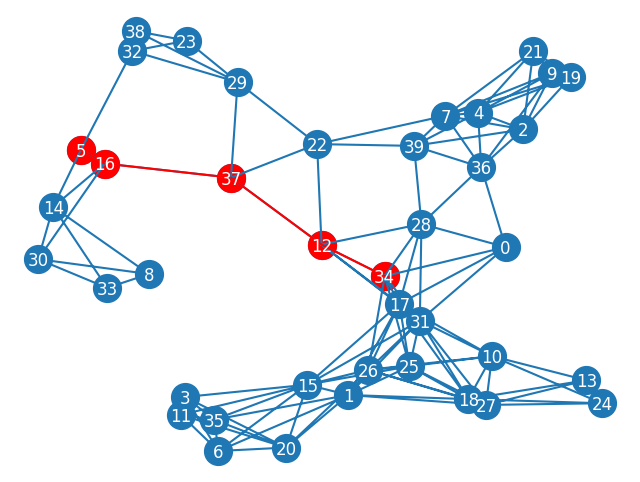

Test Result: Pass
--------------------------------------------------------------------------------
Start: 5 	Goal: 5 	Shortest Path By My Algorithm: [5] 		Actual Shortest Path: [5] 
Shortest Distance By My Algorithm: 0.0


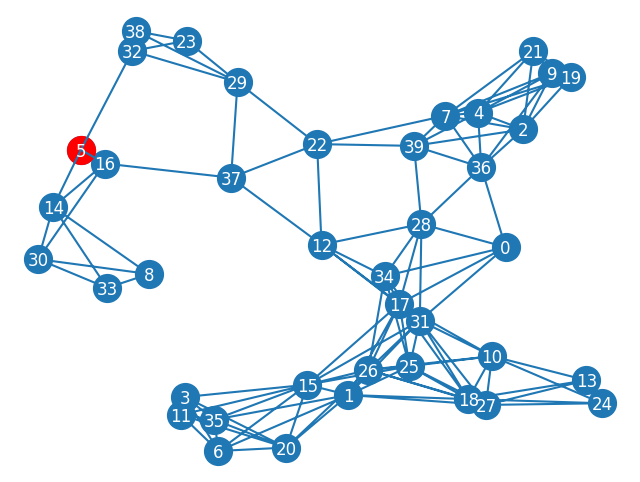

Test Result: Pass
--------------------------------------------------------------------------------
Start: 8 	Goal: 24 	Shortest Path By My Algorithm: [8, 14, 16, 37, 12, 17, 10, 24] 		Actual Shortest Path: [8, 14, 16, 37, 12, 17, 10, 24] 
Shortest Distance By My Algorithm: 1.3648778867109002


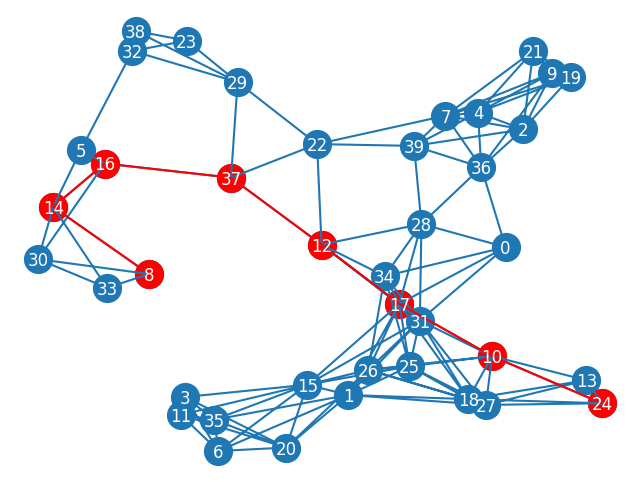

Test Result: Pass


In [27]:
# Perform tests to verify the algorithm's correctness on a larger map 
# with 40 intersections.

print(test(map_40, 5, 34, [5, 16, 37, 12, 34], 
           maps.X_LINES_40, maps.Y_LINES_40, 
           maps.X_SCATTERS_40, maps.Y_SCATTERS_40, 
           maps.MARKERS_40, True))
print(test(map_40, 5, 5, [5],
           maps.X_LINES_40, maps.Y_LINES_40, 
           maps.X_SCATTERS_40, maps.Y_SCATTERS_40, 
           maps.MARKERS_40, True))
print(test(map_40, 8, 24, [8, 14, 16, 37, 12, 17, 10, 24],
           maps.X_LINES_40, maps.Y_LINES_40, 
           maps.X_SCATTERS_40, maps.Y_SCATTERS_40, 
           maps.MARKERS_40, True))

**In summary, by providing the map, origin, and destination as input, the route planner algorithm can efficiently suggest the shortest path that minimizes the distance between the origin and destination, irrespective of the map's complexity.**